In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import xgboost as xgb
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

def prepareData(lag):
    # all data
    prec = pd.read_csv('../data/MH25_vaisalawxt520prec_2017.csv')
    wind = pd.read_csv('../data/MH25_vaisalawxt520windpth_2017.csv')
    temp = pd.read_csv('../data/MH30_temperature_rock_2017.csv')
    radio = pd.read_csv('../data/MH15_radiometer__conv_2017.csv')

    # join all data by time
    temp0 = pd.merge(left=temp, right=prec, left_on='time', right_on='time')
    temp0 = pd.merge(left=temp0, right=wind, left_on='time', right_on='time')
    temp0 = pd.merge(left=temp0, right=radio, left_on='time', right_on='time')

    # format season and remove datetime
    temp0['time'] = pd.to_datetime(temp0['time'])
    temp0['season'] = np.round(pd.DatetimeIndex(temp0['time']).month/3)
    del temp0['time']

    # difference between ground and deepest temperature --> objective
    diff = (temp0['temperature_100cm [°C]'] - temp0['temperature_5cm [°C]'])
    temp0.insert(0, 'delta_t', diff)

    # shift 
    temp0['delta_t'] = temp0['delta_t'].shift(lag)

    # remove useless columns
    del temp0['position []_x']
    del temp0['position []_y']

    # show correlation (within same time period)
    #print(abs(temp0.corr()['delta_t']).sort_values(ascending=False))

    # clean column names and remove inf/nas
    temp0.columns = temp0.columns.str.replace("[", "_")
    temp0.columns = temp0.columns.str.replace("]", "_")
    temp0 = temp0.fillna(0)
    return temp0

In [6]:
temp0 = prepareData(0)
shift = 1

n = temp0.shape[0]
preds = np.zeros(shape=(n,))
for i in range(1,n):
    preds[i] = temp0.iloc[i-shift,0]
    
# to compare it with the test data (y_test)
sep = int(np.round(0.7 * n))

y_test = temp0.iloc[sep+1:n, 0]
preds = preds[sep+1:]


ae = abs(preds-y_test)
se = np.sqrt((ae ** 2).mean())
print("The RMSE is " + str(se))

The RMSE is 0.2487951460027581


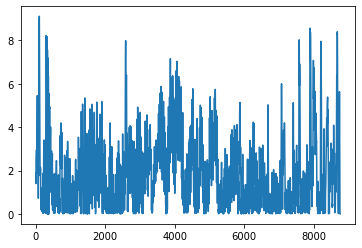

In [36]:
plt.plot(temp0['delta_t'])